## Imports + utility functions

In [1]:
%matplotlib inline

import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
import rioxarray as rxr
import matplotlib.pyplot as plt
from pystac_client import Client
import stackstac

In [2]:
def get_bbox(geojson):
    """Extracts bounding box coordinates from an input vector data file"""
    gdf = gpd.read_file(geojson)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    bbox = tuple([float(b) for b in gdf.total_bounds])

    return bbox


def get_utm_epsg(stac_item):
    """Returns WGS/UTM zone in EPSG format for a STAC item"""
    # Get centroid of item extent geometry from properties
    polygon = Polygon(stac_item.geometry['coordinates'][0])
    centroid = polygon.centroid
    
    # Calculate zone based on coords and return
    utm_zone = str(int((centroid.x + 180) // 6) + 1).zfill(2)
    if centroid.y > 0:
        utm_epsg = int(f'{326}{utm_zone}')
    else:
        utm_epsg = int(f'{327}{utm_zone}')
    
    return utm_epsg

## Accessing Data from STAC

In [3]:
# Define spatial filter and date range for API query
# GeoJSON sourced from https://opendata.thunderbay.ca/datasets/eb91862c4d064944b7550b3fee2066e4_0/explore
tb_geojson_path = './thunder_bay_urban_area.geojson'
tb_aoi_gdf = gpd.read_file(tb_geojson_path)
tb_bbox = get_bbox(tb_geojson_path)

start_date = '2025-01-01'
end_date = '2025-12-31'

In [4]:
# List all RCM-CARD items in collection satisfying search criteria
cat_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/stac/'
catalog = Client.open(cat_url)
search = catalog.search(
    collections=['rcm-ard'],
    bbox=tb_bbox,
    datetime=f'{start_date}/{end_date}',
    limit=500
)

items = search.item_collection()
print(f'{len(items)} products found')

12 products found


### Reading data from the STAC in native CRS

In [5]:
# All RCM-CARD products are stored in their respective WGS/UTM projection
item_tb = items[1]
utm_crs = get_utm_epsg(item_tb)
print(f'RCM-CARD scene is originally projected in EPSG:{utm_crs}')

RCM-CARD scene is originally projected in EPSG:32616


In [6]:
# Get native pixel resolution for data assets
resolution = (item_tb.properties['product_row_spacing'], item_tb.properties['product_column_spacing'])
print(f'STAC raster assets have a {resolution} m pixel resolution')

STAC raster assets have a (20.0, 20.0) m pixel resolution


In [7]:
# Stack selected assets into rioxarray dataset
asset_list = ['rl', 'rr']
stack_tb = stackstac.stack(item_tb,
                           assets=asset_list,
                           bounds_latlon=tb_bbox,  # only loading pixels within our bounding b
                           resolution=resolution,
                           epsg=utm_crs
                           )
stack_tb.attrs['long_name'] = asset_list
print(f'All raster assets are projected in their native {stack_tb.rio.crs} with a {stack_tb.rio.resolution()[0]}m resolution')

All raster assets are projected in their native EPSG:32616 with a 20.0m resolution


Text(0.5, 1.0, 'RR polarization within Thunder Bay AOI')

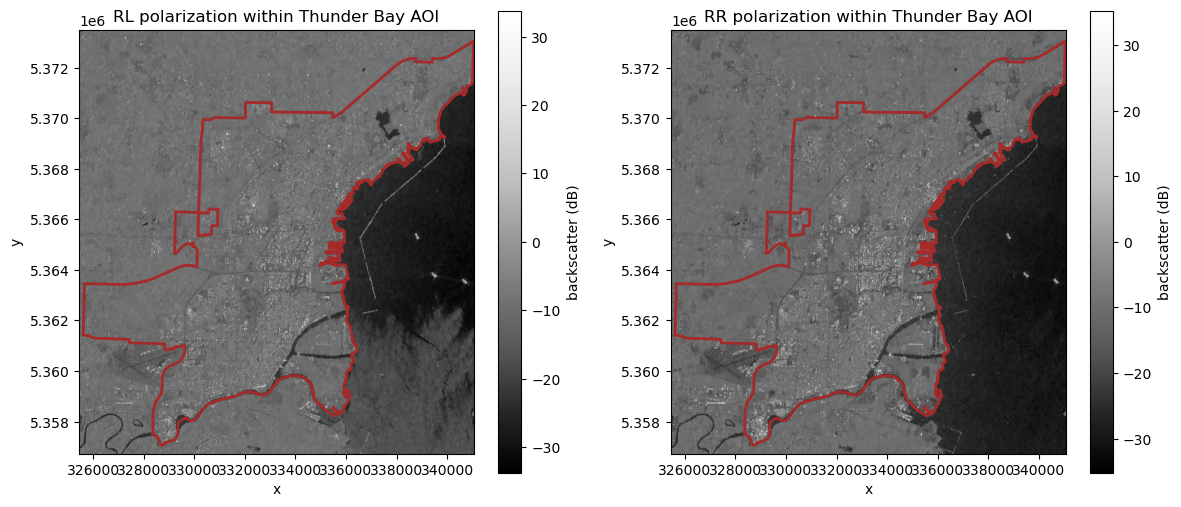

In [8]:
# Convert RL/RR assets to DB and plot alongside each other
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
rl_db_utm = 10 * np.log10(stack_tb.sel(band='rl'))
rl_db_utm.attrs['long_name'] = 'backscatter (dB)'
rl_db_utm.plot(ax=axes[0], cmap='Greys_r')
tb_aoi_gdf.to_crs(utm_crs).plot(facecolor='none', edgecolor='brown', linewidth=2, ax=axes[0])
axes[0].set_title('RL polarization within Thunder Bay AOI')

rr_db_utm = 10 * np.log10(stack_tb.sel(band='rr'))
rr_db_utm.attrs['long_name'] = 'backscatter (dB)'
rr_db_utm.plot(ax=axes[1], cmap='Greys_r')
tb_aoi_gdf.to_crs(utm_crs).plot(facecolor='none', edgecolor='brown', linewidth=2, ax=axes[1])
axes[1].set_title('RR polarization within Thunder Bay AOI')

### Reading data from STAC using an alternative CRS

Government of Canada Open Data is often provided in Lambert Conformal Conic (EPSG:3979).

We can transform raster coordinates on-the-fly to match this when reading from the STAC like so:

In [9]:
# New example within Canada's Northwest Territories
nwt_geojson_path = './nwt_example.geojson'
nwt_bbox = get_bbox(nwt_geojson_path)

search = catalog.search(
    collections=['rcm-ard'],
    bbox=nwt_bbox,
    datetime=f'{start_date}/{end_date}',
    limit=100
)

items = search.item_collection()
nwt_ok = 'RCM1_OK3555463_PK3632926_2_SC30MCPC_20250602_022654_CH_CV_MLC'  # known scene with full AOI coverage
item_nwt = [i for i in items if i.properties['order_key'] == nwt_ok][0]

In [10]:
# Read susbset of RCM scene into an array using alternate CRS
lcc_epsg = 3979
stack_nwt_lcc = stackstac.stack(item_nwt,
                                assets=asset_list,
                                bounds_latlon=nwt_bbox,
                                resolution=resolution,
                                epsg=lcc_epsg  # specify CRS to read data into
                                )
stack_nwt_lcc.attrs['long_name'] = asset_list
print(f'Successfully read RCM-CARD data into array using {stack_nwt_lcc.rio.crs} on-the-fly with stackstac!')

Successfully read RCM-CARD data into array using EPSG:3979 on-the-fly with stackstac!


### Reprojecting stacked rioxarray data

We can also read the data from our STAC catalog into its native CRS, then reproject into another to create a new data array

In [11]:
# Using same nwt Island AOI, read data into array using its native WGS/UTM projection
nwt_utm_crs = get_utm_epsg(item_nwt)
stack_nwt_utm = stackstac.stack(item_nwt,
                                assets=asset_list,
                                bounds_latlon=nwt_bbox,
                                resolution=resolution,
                                epsg=nwt_utm_crs
                                )
stack_nwt_utm.attrs['long_name'] = asset_list
print(f'Loaded item {item_nwt.properties["order_key"]} using native CRS of {stack_nwt_utm.rio.crs}')

Loaded item RCM1_OK3555463_PK3632926_2_SC30MCPC_20250602_022654_CH_CV_MLC using native CRS of EPSG:32608


In [12]:
# Reproject the dataset into EPSG:3979 (lambert Conformal Conic)
stack_nwt_reproj = stack_nwt_utm[0, :, :, :].rio.reproject(lcc_epsg)  # drop redundant time dimension
print(f'Reprojected data stack from {stack_nwt_utm.rio.crs} to {stack_nwt_reproj.rio.crs}!')

Reprojected data stack from EPSG:32608 to EPSG:3979!


Text(0.5, 1.0, 'RR polarization reprojected to EPSG:3979')

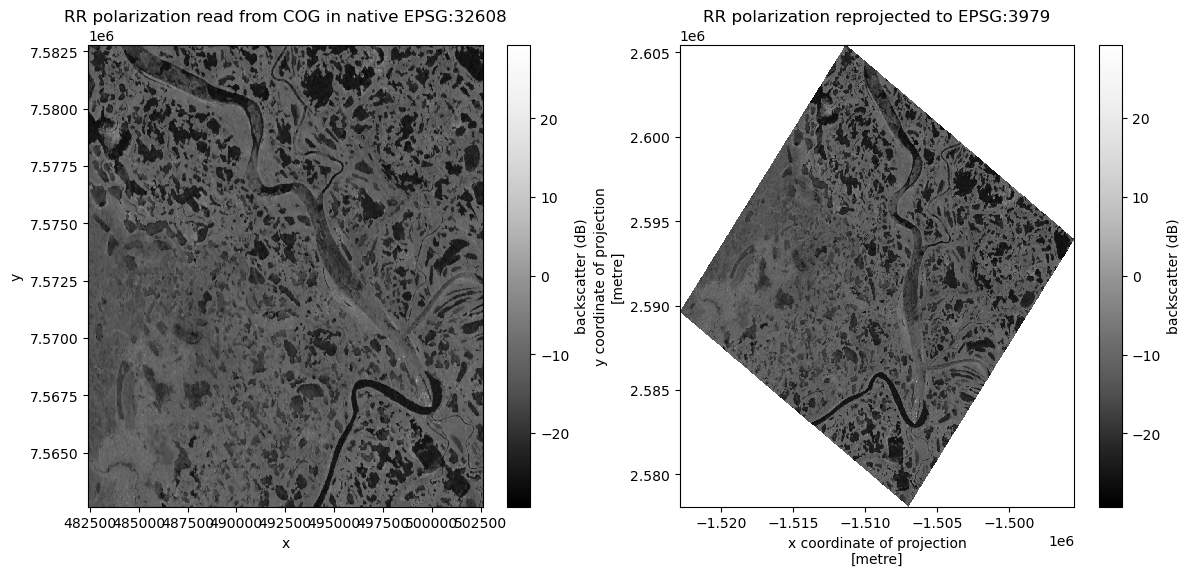

In [13]:
# Comparing projections side-by-side
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
rr_db_utm = 10 * np.log10(stack_nwt_utm[0, :, :].sel(band='rr'))
rr_db_utm.attrs['long_name'] = 'backscatter (dB)'
rr_db_utm.plot(ax=axes[0], cmap='Greys_r')
axes[0].set_title(f'RR polarization read from COG in native {stack_nwt_utm.rio.crs}')

rr_db_reproj = 10 * np.log10(stack_nwt_reproj.sel(band='rr'))
rr_db_reproj.attrs['long_name'] = 'backscatter (dB)'
rr_db_reproj.plot(ax=axes[1], cmap='Greys_r')
axes[1].set_title(f'RR polarization reprojected to {stack_nwt_reproj.rio.crs}')